In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report

In [2]:
#Loading the data:
df = pd.read_csv("Out/cleaned_training_data.csv")

### One-hot encoding

#### Categorical Feature Encoding

All binary categorical features in the dataset are already properly encoded. (i.e., they contain only two distinct values such as 0 and 1). Since binary features are already in a format suitable for machine learning models, **no further one-hot encoding is required**. Therefore, we do not apply any additional transformation for categorical variables in this case.

In [3]:
# Check if all columns are now numeric
print("All numeric?", df.dtypes.apply(lambda dtype: np.issubdtype(dtype, np.number)).all())

All numeric? True


### Machine Learning

#### Splitting the dataset into  train, validation, and test sub-samples.

In [4]:
X = df.drop(columns='TARGET')  # Features
y = df['TARGET']  # Target

# First split: train+val and test (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: train and val (75% train, 25% val from the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Print the shapes to confirm the splits
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (45612, 306), Validation shape: (15204, 306), Test shape: (15204, 306)


In [5]:
# --- 1. Train Random Forest Classifier ---

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val)
y_val_prob_rf = rf_model.predict_proba(X_val)[:, 1]  # Get probabilities for log loss

# Evaluate Random Forest performance
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
log_loss_rf = log_loss(y_val, y_val_prob_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Log Loss: {log_loss_rf:.4f}")

# --- 2. Train XGBoost Classifier ---

# Initialize the model
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate XGBoost performance
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
log_loss_xgb = log_loss(y_val, y_val_prob_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Log Loss: {log_loss_xgb:.4f}")

Random Forest Accuracy: 0.9551
Random Forest Log Loss: 0.3330
XGBoost Accuracy: 0.9607
XGBoost Log Loss: 0.1410


I trained and evaluated two classification models—Random Forest and XGBoost—to predict customer satisfaction based on the prepared dataset. Both models were trained on the training set and evaluated on the validation set using accuracy and log loss as metrics.

Both models achieved high accuracy, indicating that they performed well on the validation data overall.However, XGBoost outperformed Random Forest in both accuracy and log loss.

Now, let's proceed to visualizing the ROC curves of these models.

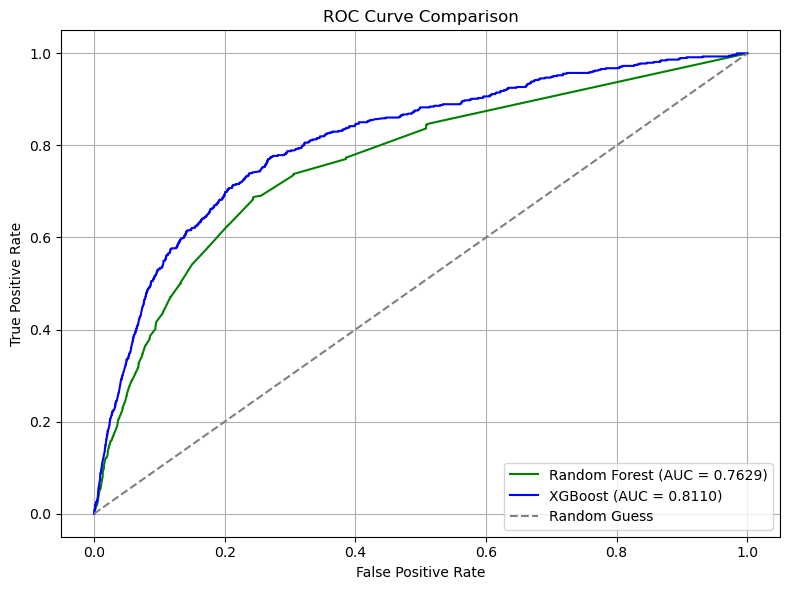

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curves and AUC scores
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_val_prob_xgb)
auc_rf = roc_auc_score(y_val, y_val_prob_rf)
auc_xgb = roc_auc_score(y_val, y_val_prob_xgb)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


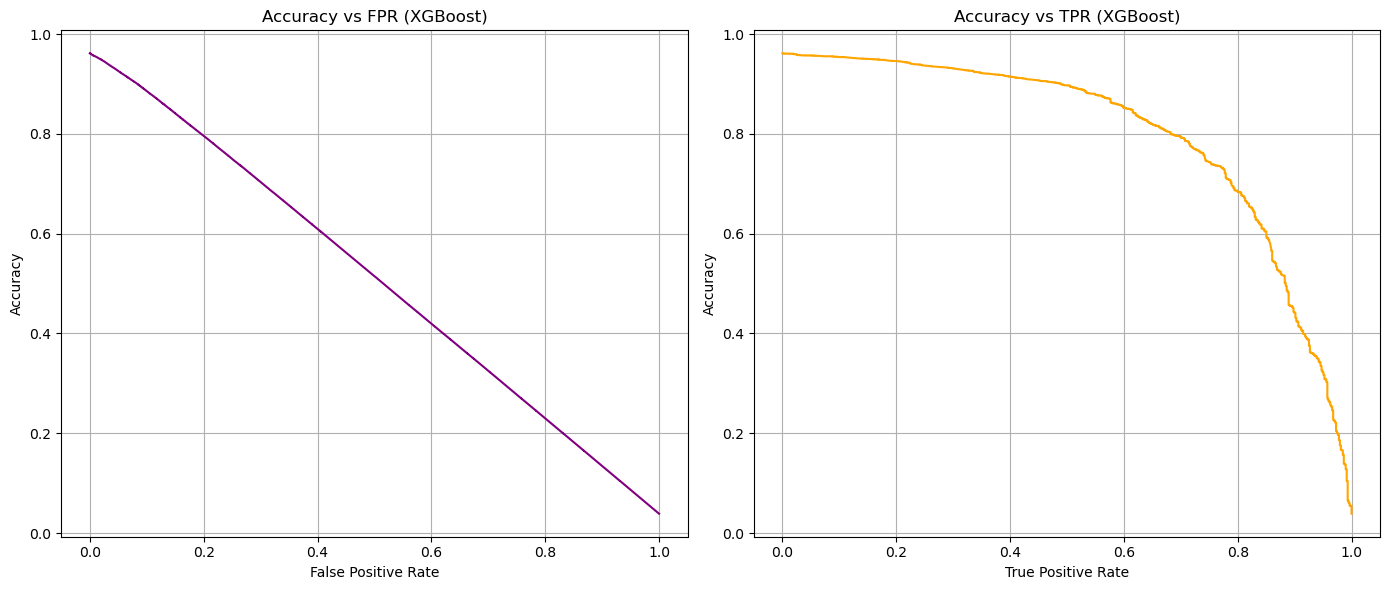

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Get ROC values and thresholds
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val, y_val_prob_xgb)

# Initialize accuracy list
accuracy_scores = []

# Compute accuracy at each threshold
for thresh in thresholds_xgb:
    y_pred_thresh = (y_val_prob_xgb >= thresh).astype(int)
    acc = (y_pred_thresh == y_val).mean()
    accuracy_scores.append(acc)

# Plot Accuracy vs FPR and Accuracy vs TPR
plt.figure(figsize=(14, 6))

# Accuracy vs FPR
plt.subplot(1, 2, 1)
plt.plot(fpr_xgb, accuracy_scores, label='Accuracy vs FPR', color='purple')
plt.xlabel('False Positive Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs FPR (XGBoost)')
plt.grid(True)

# Accuracy vs TPR
plt.subplot(1, 2, 2)
plt.plot(tpr_xgb, accuracy_scores, label='Accuracy vs TPR', color='orange')
plt.xlabel('True Positive Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs TPR (XGBoost)')
plt.grid(True)

plt.tight_layout()
plt.show()


### Cross Validation Check

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Initialize models
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)

# Perform 5-Fold Cross-Validation
print("Random Forest Cross-Validation:")
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Scores: {rf_scores}")
print(f"Mean Accuracy: {rf_scores.mean():.4f}")

print("\nXGBoost Cross-Validation:")
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Scores: {xgb_scores}")
print(f"Mean Accuracy: {xgb_scores.mean():.4f}")


Random Forest Cross-Validation:
Scores: [0.95253754 0.95209909 0.95428634 0.95362859 0.95297084]
Mean Accuracy: 0.9531

XGBoost Cross-Validation:
Scores: [0.95955278 0.959772   0.96009647 0.95998684 0.95943872]
Mean Accuracy: 0.9598


Xgboost is performing slighlty better than random Forest in accuracy and log loss. Cross validation also further confirmed the same.

### Apply ML to the challenge test set

In [8]:
test_df = pd.read_csv("Kaggle/test.csv")
df.shape, test_df.shape

((76020, 307), (75818, 370))

In [9]:
submission_df = test_df[["ID"]]

In [10]:
# Repeating Pre-processing steps in test dataset.
test_df = test_df.drop("ID", axis=1)

# Find and drop constant columns
constant_columns = [col for col in test_df.columns if test_df[col].nunique() == 1]
test_df = test_df.drop(columns=constant_columns)

# remove redundancy between features (duplicates of other columns)
from sklearn.base import BaseEstimator, TransformerMixin

class DropDuplicateFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.duplicated_feature_sets_ = []
        
    def fit(self, X, y=None):
        X = X.copy()
        seen = {}
        self.duplicated_feature_sets_ = []
        
        for col in X.columns:
            col_bytes = X[col].values.tobytes()
            if col_bytes in seen:
                self.duplicated_feature_sets_.append((seen[col_bytes], col))
            else:
                seen[col_bytes] = col
        return self
    
    def transform(self, X):
        X = X.copy()
        to_drop = [dup[1] for dup in self.duplicated_feature_sets_]
        return X.drop(columns=to_drop)


duplicates = DropDuplicateFeatures()
duplicates.fit(test_df)
test_df = duplicates.transform(test_df)

In [11]:
test_df.shape

(75818, 299)

In [12]:
## Appling the model to the test data set

X = df.drop(columns='TARGET')  # Features
feature_columns = X.columns.tolist()

# Identify missing columns
missing_cols = list(set(feature_columns) - set(test_df.columns))

# Add missing columns with default value (e.g., 0)
for col in missing_cols:
    test_df[col] = 0


X_test = test_df[feature_columns]

# Predict using Random Forest
y_test_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_test_pred_rf = rf_model.predict(X_test)

# Predict using XGBoost
y_test_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_test_pred_xgb = xgb_model.predict(X_test)


In [13]:
# creating a submission file.
submission = pd.DataFrame({
    "ID": test_df.index,  # Or use test_df['ID'] if ID is a column
    "TARGET": y_test_pred_xgb.astype(int),  # Binary class 0 or 1
    "Unsatisfied Customer Probability": y_test_prob_xgb  # Float probability
})

# Save to CSV
import os
if not os.path.exists("Out"):
    os.makedirs("Out")
submission.to_csv("Out/xgb_submission.csv", index=False)
